# Import Libraries


In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from lime.lime_tabular import LimeTabularExplainer

---
# Data

In [2]:
# Define the range for x and y
feature_1_lower_bound, feature_1_upper_bound = -10, 10
feature_2_lower_bound, feature_2_upper_bound = -10, 10
n_samples = 1000

In [3]:
def cosine_decision_boundary_function(x: np.ndarray) -> np.ndarray:
    return np.cos(x * math.pi / 10)*10

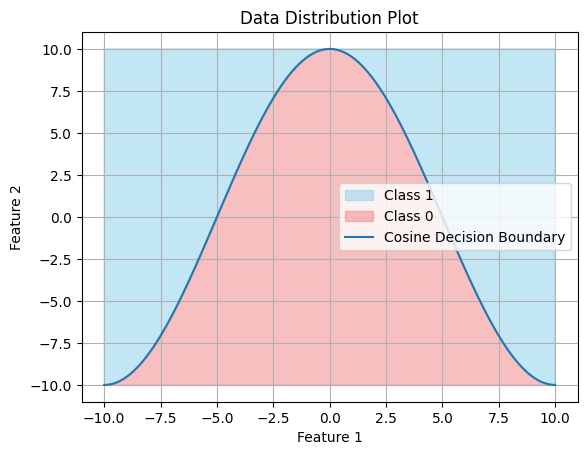

In [4]:
feature_1_values = np.linspace(feature_1_lower_bound, feature_1_upper_bound, 400)

# Compute  values using the cosine_decision_boundary_function
decision_boundary_values = cosine_decision_boundary_function(feature_1_values)

# Fill the area above the decision boundary
plt.fill_between(
    feature_1_values,
    decision_boundary_values,
    y2=max(decision_boundary_values),
    where=(decision_boundary_values < max(decision_boundary_values)),
    color="skyblue",
    alpha=0.5,
    label="Class 1",
)

# Fill the area below the decision boundary
plt.fill_between(
    feature_1_values,
    decision_boundary_values,
    y2=min(decision_boundary_values),
    where=(decision_boundary_values > min(decision_boundary_values)),
    color="lightcoral",
    alpha=0.5,
    label="Class 0",
)

plt.plot(feature_1_values, decision_boundary_values, label="Cosine Decision Boundary")

plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Data Distribution Plot")
plt.legend()
plt.grid(True)

In [5]:
def X_to_y(X: np.ndarray) -> np.ndarray:
    feature_1_values = X[:, 0]
    feature_2_values = X[:, 1]

    decision_boundar_values = cosine_decision_boundary_function(feature_1_values)

    classes = np.where(feature_2_values > decision_boundar_values, 1, 0)

    return classes

In [6]:
# Generate random points within the specified range
feature_1_samples = np.random.uniform(
    feature_1_lower_bound, feature_1_upper_bound, n_samples
)
feature_2_samples = np.random.uniform(
    feature_2_lower_bound, feature_2_upper_bound, n_samples
)

# Create input X for
X = np.array([feature_1_samples, feature_2_samples]).T
y = X_to_y(X)

X[:5, :], y[:5]

(array([[ 5.17989716, -9.55767981],
        [-5.67073763,  5.74974307],
        [ 9.29301158,  4.94707715],
        [ 2.65981303,  1.35125955],
        [ 4.98468752,  7.15607795]]),
 array([0, 1, 1, 0, 1]))

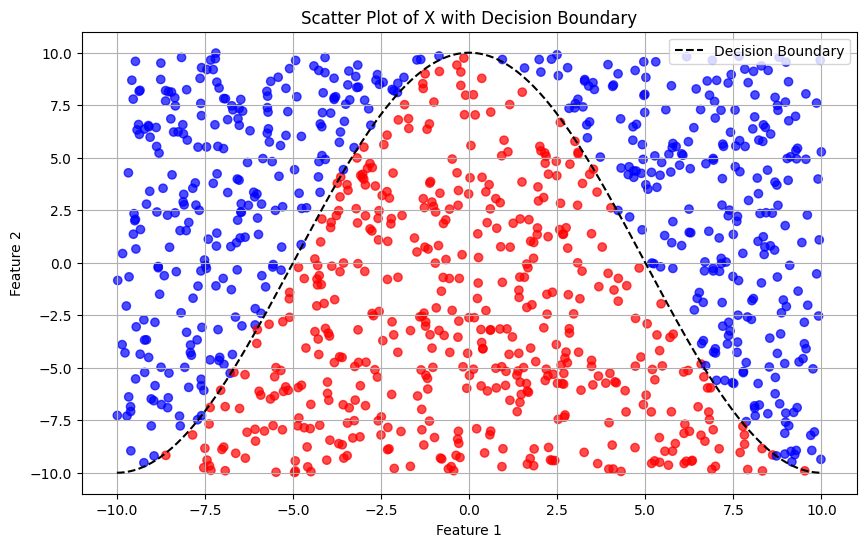

In [7]:
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], X[:, 1], c=-y, cmap="bwr", alpha=0.7)
plt.plot(
    feature_1_values,
    decision_boundary_values,
    color="black",
    linestyle="--",
    label="Decision Boundary",
)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Scatter Plot of X with Decision Boundary")
plt.legend()
plt.grid(True)
plt.show()

---
# Model

In [8]:
TEST_SIZE = 0.2

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE)

In [10]:
# class CustomClassifier(BaseEstimator, ClassifierMixin):
#     def __init__(self, threshold=0.5):
#         self.threshold = threshold

#     def fit(self, X, y):
#         # For simplicity, this custom classifier doesn't actually train on the data
#         self.classes_ = 2
#         return self

#     def predict(self, X):
#         # Predict class 1 if the mean of the features is above the threshold, else class 0
#         return (np.mean(X, axis=1) > self.threshold).astype(int)

#     def predict_proba(self, X):
#         # Return probabilities based on the threshold
#         proba = np.zeros((X.shape[0], len(self.classes_)))
#         proba[:, 1] = np.mean(X, axis=1) > self.threshold
#         proba[:, 0] = 1 - proba[:, 1]
#         return proba

In [11]:
classifier = RandomForestClassifier()
classifier.fit(X_train, y_train)
classifier.score(X_test, y_test)

0.975

---
# Lime Explaination

In [12]:
explainer = LimeTabularExplainer(
    X_train,
    feature_names=["Feature 1", "Feature 2"],
    class_names=["Class 0", "Class 1"],
    discretize_continuous=True,
)

In [13]:
explanation_instance_idx = 3  #

explanation_instance_X = X_test[explanation_instance_idx, :]
explanation_instance_y = y_test[explanation_instance_idx]
explanation_instance_y_predict_proba = classifier.predict_proba


explanation_instance_X, explanation_instance_y_predict_proba, explanation_instance_y

(array([ 6.84973576, -5.95900691]),
 <bound method ForestClassifier.predict_proba of RandomForestClassifier()>,
 np.int64(0))

In [16]:
exp = explainer.explain_instance(
    explanation_instance_X,
    explanation_instance_y_predict_proba,
    num_features=2,
    top_labels=2,
)
exp.show_in_notebook(show_table=True, show_all=False)

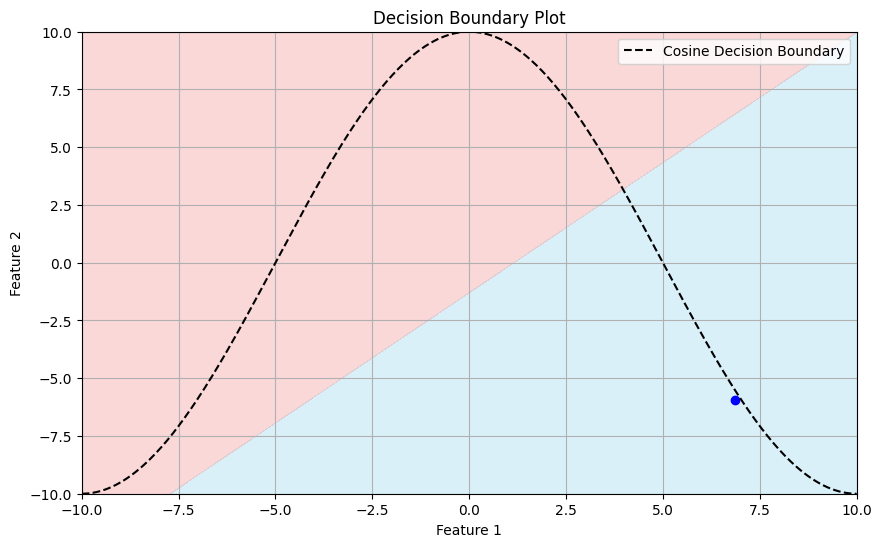

In [15]:
# Extract the intercept and local explanation coefficients
intercept = float(exp.intercept[0])
coefficients = {int(key): float(value) for key, value in exp.local_exp[0]}
exp_pred_class = int(exp.top_labels[0])

color_dict = {0: "Blue", 1: "Red"}

# Create a mesh grid for plotting
xx, yy = np.meshgrid(
    np.linspace(feature_1_lower_bound, feature_1_upper_bound, 100),
    np.linspace(feature_2_lower_bound, feature_2_upper_bound, 100),
)

# Calculate the decision boundary
boundary = intercept + coefficients[0] * xx + coefficients[1] * yy

levels = sorted([boundary.min(), 0, boundary.max()])


# Plot the decision boundary
plt.figure(figsize=(10, 6))
plt.contourf(
    xx,
    yy,
    boundary,
    levels=levels,
    alpha=0.3,
    colors=["skyblue", "lightcoral"],
)
plt.scatter(
    explanation_instance_X[0],
    explanation_instance_X[1],
    color=color_dict[exp_pred_class],
)
plt.plot(
    feature_1_values,
    decision_boundary_values,
    color="black",
    linestyle="--",
    label="Cosine Decision Boundary",
)

x = np.linspace(feature_1_upper_bound, feature_1_upper_bound, 400)
y = -(intercept + coefficients[0] * x) / coefficients[1]
mask_line = (y >= feature_2_lower_bound) & (y <= feature_2_upper_bound)
plt.plot(x[mask_line], y[mask_line], color="black")


plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Decision Boundary Plot")
plt.legend()
plt.grid(True)
plt.show()